In [77]:
import os
from dotenv import load_dotenv
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

gemini_api_key = os.getenv("GEMINI_API_KEY")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=gemini_api_key)
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",api_key=gemini_api_key)

In [78]:
llm.invoke("hello there!").content

'Hello! How can I help you today?'

In [79]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated,Literal,TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [80]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages":[response]}

In [81]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app = workflow.compile()

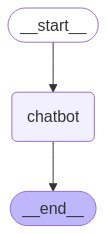

In [82]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [83]:
input={"messages":["hi, my name is neal"]}

In [84]:
app.invoke(input)

{'messages': [HumanMessage(content='hi, my name is neal', additional_kwargs={}, response_metadata={}, id='e8b920a5-ebbb-4a4e-8e25-065b3b3b5e3c'),
  AIMessage(content="Hi Neal, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-905f2caf-6be6-4931-bf62-cfdb523ec8ae-0', usage_metadata={'input_tokens': 7, 'output_tokens': 19, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}})]}

In [85]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hi Neal, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a2b6d708-140f-46ff-948d-fc9592974745-0', usage_metadata={'input_tokens': 7, 'output_tokens': 19, 'total_tokens': 26, 'input_token_details': {'cache_read': 0}})]}




starting phase2 from here with tool

In [86]:
@tool
def search(query: str):
    """this is my custom tool"""
    if "sf" in query.lower() or "san fransisco" in query.lower():
        return "It's 60 degree and foggy"
    return "It's 90 degree and sunny"

In [87]:
search.invoke("what is temprature in sf?")

"It's 60 degree and foggy"

In [88]:
search.invoke("what is temprature in india?")

"It's 90 degree and sunny"

In [89]:
tools = [search]

In [90]:
tool_node = ToolNode(tools)

In [91]:
llm_with_tool = llm.bind_tools(tools)

In [92]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tool.invoke(messages)
    return {"messages":[response]}

In [93]:
response = call_model({"messages":["hi how are you? "]})
response

{'messages': [AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6d3a57f3-d56d-4bf1-b2d8-cefc2d80c3ca-0', usage_metadata={'input_tokens': 14, 'output_tokens': 18, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}

In [94]:
messages = response['messages']
last_message = messages[-1]
last_message.tool_calls

[]

In [95]:
response = call_model({"messages":["what is a weather in India?"]})
response

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-93fe4d46-f0c8-4dfa-9b71-a2844dc3124c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': '4b9b970f-4b05-4062-8ca2-2f8a61b747a1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 15, 'output_tokens': 5, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}})]}

In [96]:
messages = response['messages']
last_message = messages[-1]
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': '4b9b970f-4b05-4062-8ca2-2f8a61b747a1',
  'type': 'tool_call'}]

Here is my Router Function

In [97]:
def router_function(state: MessagesState) -> Literal["tools",END]:
    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tools"
    return END

lets design the workflow now

In [98]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent",call_model)
workflow.add_node("tools",tool_node)

workflow.add_edge(START,"agent")

workflow.add_conditional_edges("agent",router_function,{"tools":"tools",END:END})

app = workflow.compile()

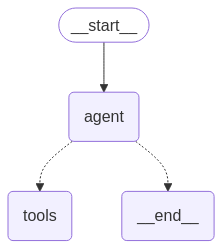

In [99]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [100]:
app.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='43034990-a945-4bd7-99ef-4bece7915a12'),
  AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6df16c0d-9bc0-4a8c-b927-331105b33062-0', usage_metadata={'input_tokens': 13, 'output_tokens': 18, 'total_tokens': 31, 'input_token_details': {'cache_read': 0}})]}

In [101]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='9cc61cb8-64ad-4ce5-896d-eb49c35c0089'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-658bdb85-32c1-429c-b7a8-df88262fc77c-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'faef124e-5efd-453a-8b97-f275d5b9664f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 14, 'output_tokens': 5, 'total_tokens': 19, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="It's 60 degree and foggy", name='search', id='607dd7ff-61b0-4585-ae60-1bc0c08e980f', tool_call_id='faef124e-5efd-453a-8b97-f275d5b9664f')]}

In [102]:
for output in app.stream({"messages":["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")


here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4bb6c28c-df3c-4153-a0f2-d772351f6e07-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': '9203364e-8878-4690-a295-d42d0719883c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 14, 'output_tokens': 5, 'total_tokens': 19, 'input_token_details': {'cache_read': 0}})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degree and foggy", name='search', id='a72abac9-2f11-4801-a151-0dc68e128219', tool_call_id='9203364e-8878-4690-a295-d42d0719883c')]}




In [103]:
workflow.add_edge("tools","agent")

app = workflow.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


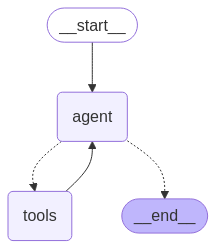

In [104]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [105]:
for output in app.stream({"messages":["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-23dcfbc3-ce5e-42c5-b8f2-7020cb6059b4-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': '87047d3c-b397-4843-9793-44c80263ca42', 'type': 'tool_call'}], usage_metadata={'input_tokens': 14, 'output_tokens': 5, 'total_tokens': 19, 'input_token_details': {'cache_read': 0}})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degree and foggy", name='search', id='44fa95c7-27f2-4e6c-adc1-0993bc9a95ae', tool_call_id='87047d3c-b397-4843-9793-44c80263ca42')]}


here is output from agent
_______
{'messages': [AIMessage(content="It's 60 degrees and foggy in San Francisco.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_r

Strating Phase 3 from here with memory and checkpointing

In [106]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [107]:
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent",call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

app3 = workflow3.compile(checkpointer= memory)

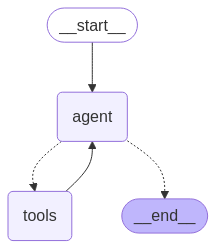

In [108]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [109]:
config = {"configurable": {"thread_id":1}}

In [115]:
# events = app3.stream(
#     {"messages": ["Hi there! My name is Neal."]}, config, stream_mode="values"
# )
events = app3.stream(
    {"messages": ["Hi there! My name is Neal and I am 21 Years old."]}, config, stream_mode="values"
)

In [116]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Neal and I am 21 Years old.
================================== Ai Message ==================================

Nice to meet you, Neal! I'm here to help you with any questions you have.


In [117]:
events = app3.stream(
    {"messages":["can you tell me what is my age?"]},config, stream_mode= "values"
)

In [118]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what is my age?
================================== Ai Message ==================================

You are 21 years old.
